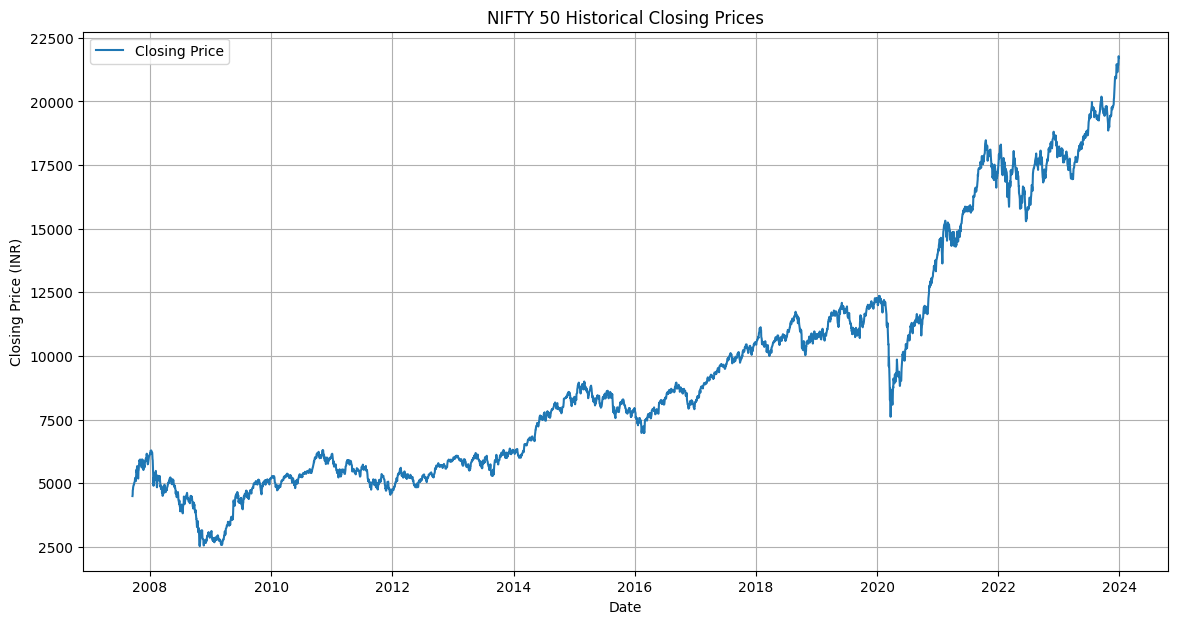

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 0.0098 - val_loss: 3.8060e-04


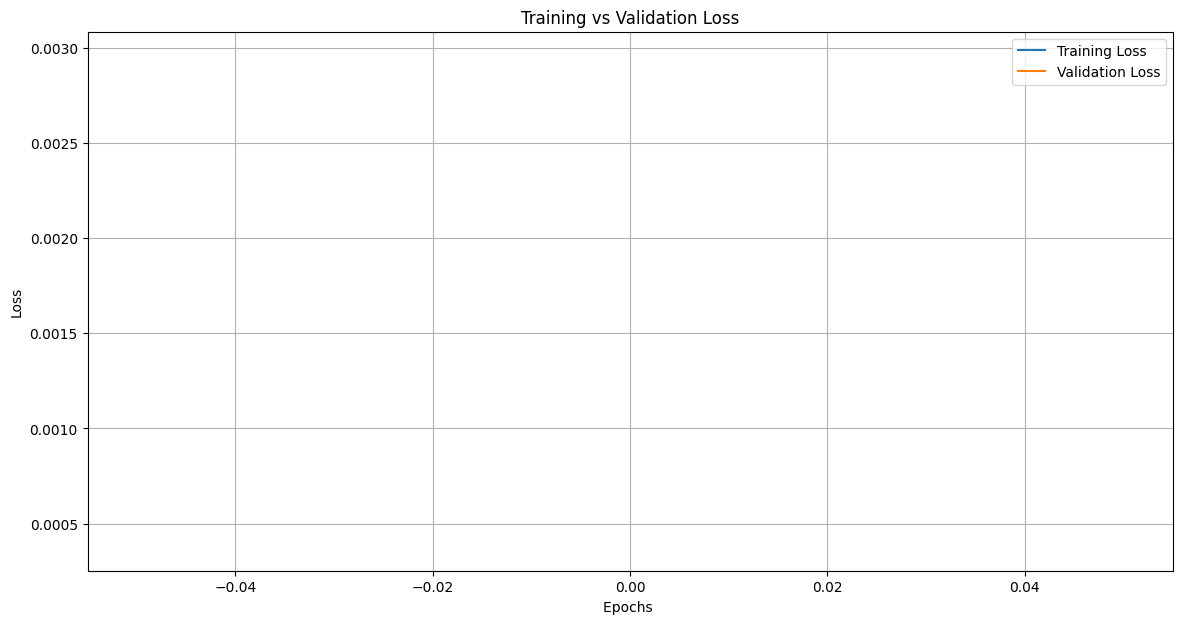

99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


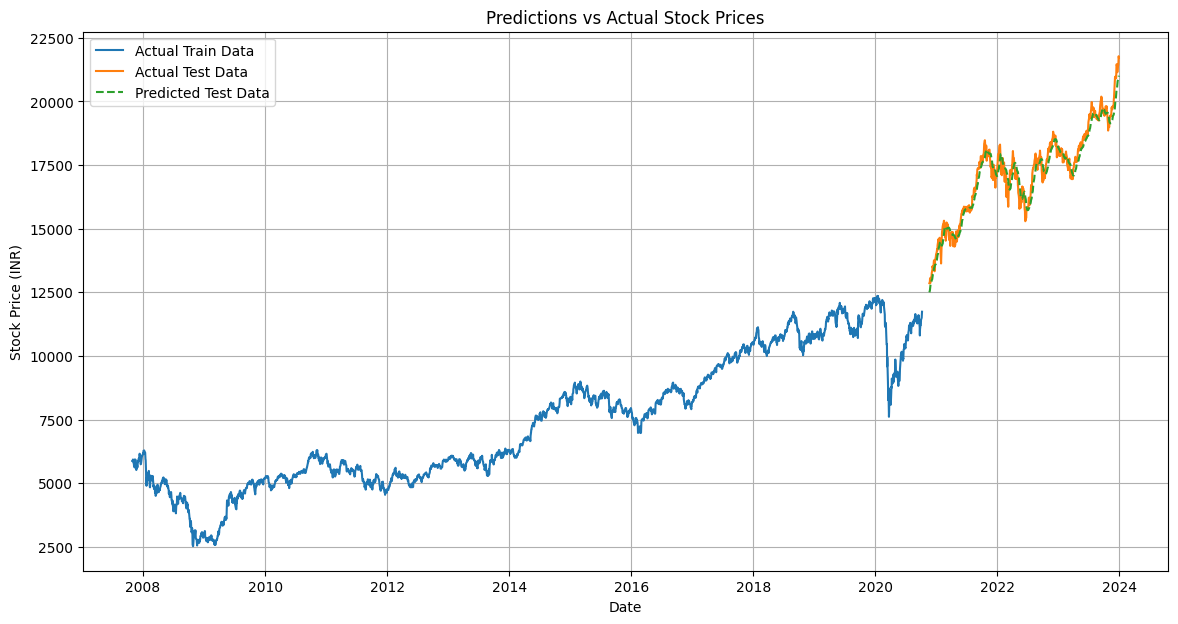

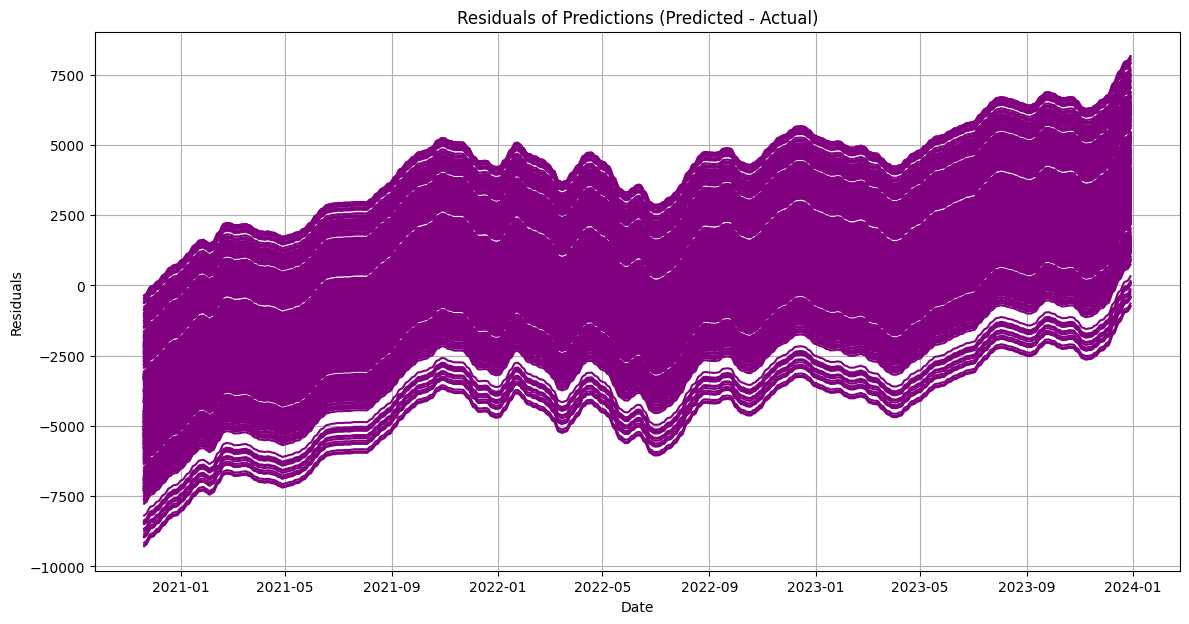

MAE (Mean Absolute Error): 299.9696097305754
RMSE (Root Mean Squared Error): 375.6361298135698
R² (Coefficient of Determination): 0.9534858887719505


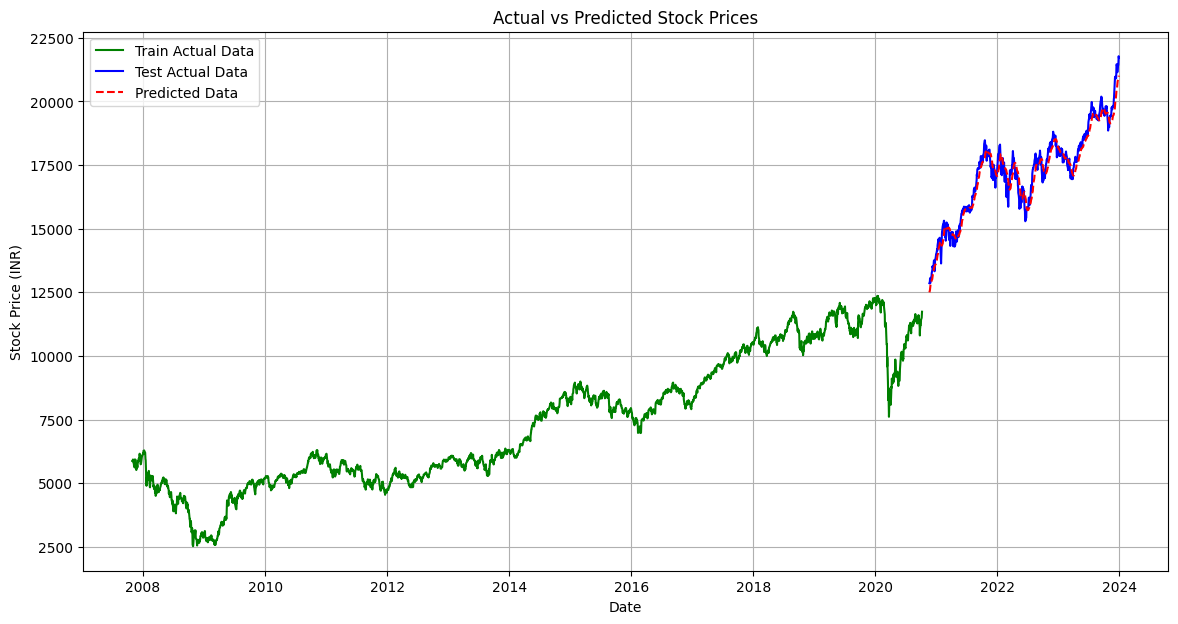

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


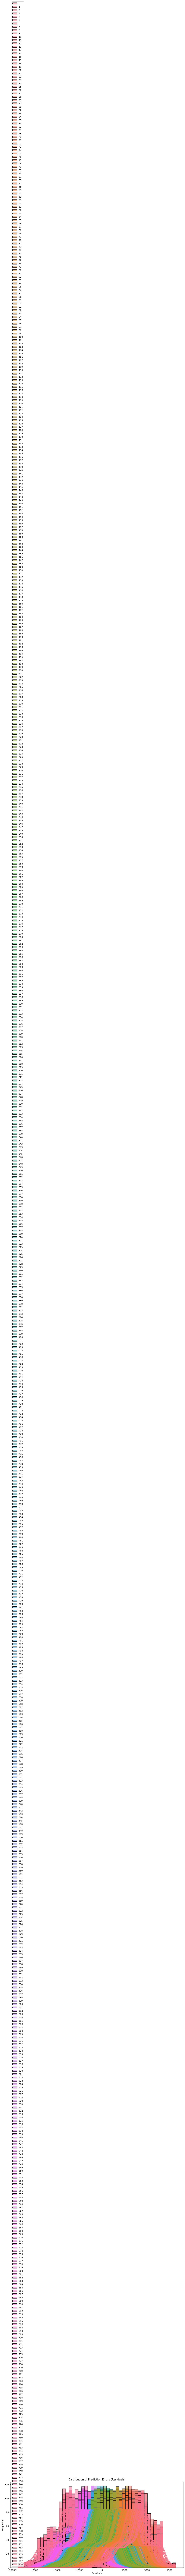

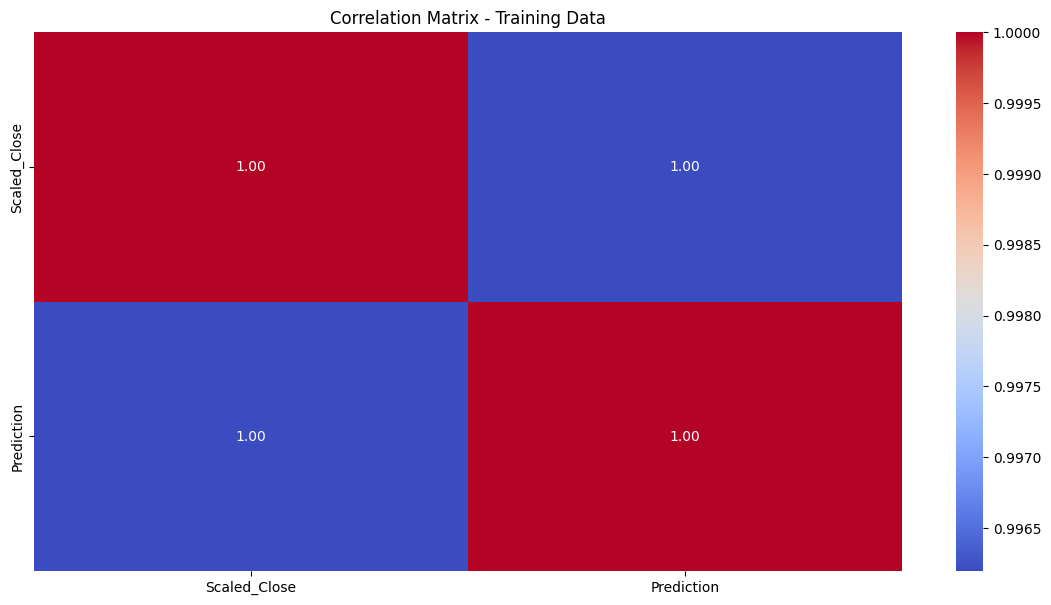

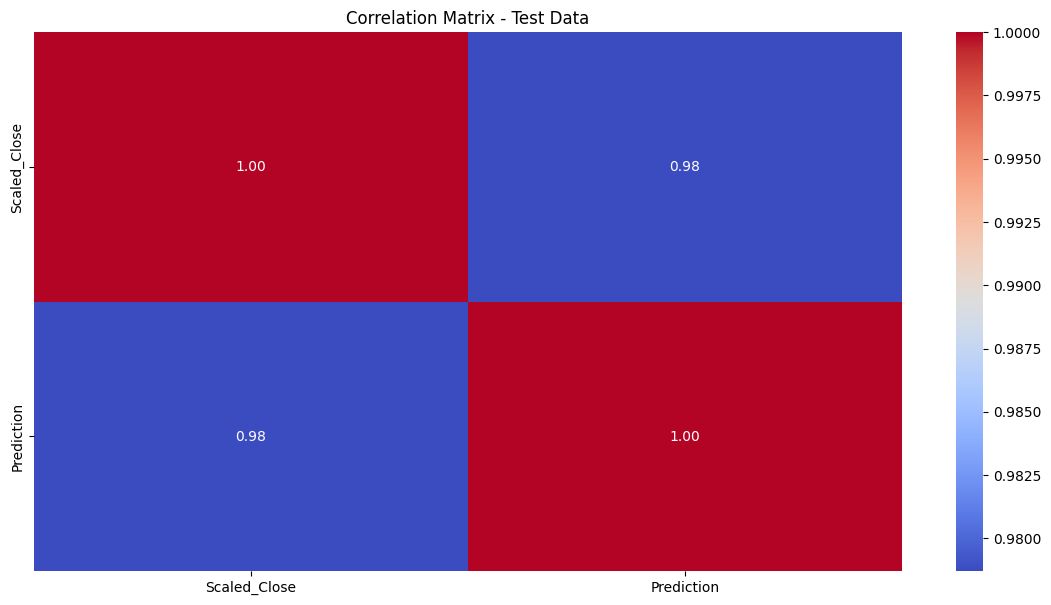

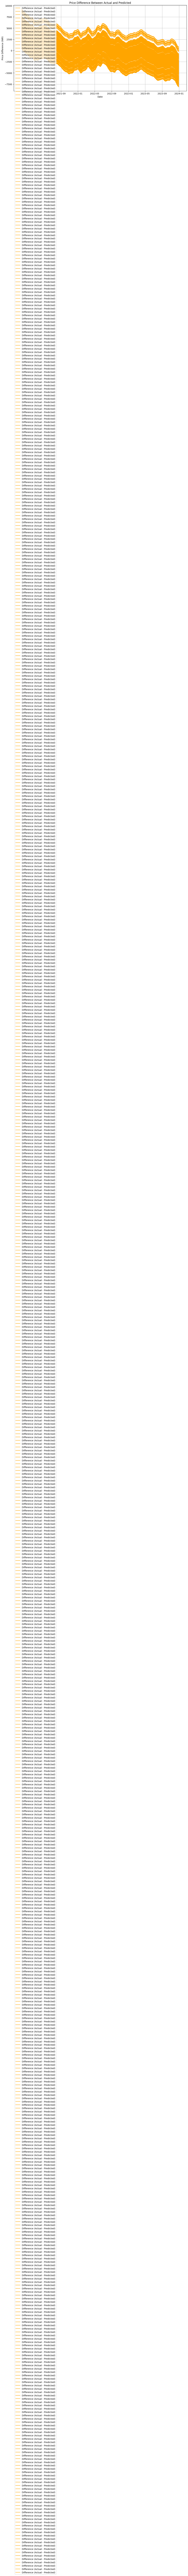

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import yfinance as yf
import seaborn as sns

# Download NIFTY 50 data from Yahoo Finance using yfinance
nifty = yf.download('^NSEI', start='2000-01-01', end='2024-01-01', progress=False)

# Use the 'Close' price for predictions
df = nifty[['Close']]

# Plotting the historical closing prices
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Closing Price')
plt.title("NIFTY 50 Historical Closing Prices")
plt.xlabel("Date")
plt.ylabel("Closing Price (INR)")
plt.grid(True)
plt.legend()
plt.show()

# Preprocessing: Scaling the 'Close' prices
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df[['Close']])

# Splitting the data into training and testing sets (80% train, 20% test)
train_size = int(len(df) * 0.8)
train, test = df_scaled[:train_size], df_scaled[train_size:]

# Function to create datasets for LSTM input
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Creating dataset for LSTM (Using 30 days to predict next day's closing price)
time_step = 30
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

# Reshaping data to 3D format for LSTM [samples, time_steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Plotting training and validation loss
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs ")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Predictions on the training and test sets
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse scaling of predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_actual = scaler.inverse_transform([y_train])
y_test_actual = scaler.inverse_transform([y_test])

# Adjusting the index to match the time_step offset
train_index = df.index[time_step:train_size]
test_index = df.index[train_size + time_step:]

# Fixing the length mismatch issue
train_predict = train_predict[:len(train_index)]
test_predict = test_predict[:len(test_index)]

# Plotting predictions vs actual values for the test dataset
plt.figure(figsize=(14, 7))
plt.plot(train_index, y_train_actual[0], label='Actual Train Data')
plt.plot(test_index, y_test_actual[0], label='Actual Test Data')
plt.plot(test_index, test_predict, label='Predicted Test Data', linestyle='dashed')
plt.title("Predictions vs Actual Stock Prices")
plt.xlabel("Date")
plt.ylabel("Stock Price (INR)")
plt.legend()
plt.grid(True)
plt.show()

# Residuals (Prediction errors)
residuals = test_predict - y_test_actual[0]
plt.figure(figsize=(14, 7))
plt.plot(test_index, residuals, label='Residuals', color='purple')
plt.title("Residuals of Predictions (Predicted - Actual)")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

# Performance Metrics: MAE, RMSE, R²
mae = mean_absolute_error(y_test_actual[0], test_predict)
rmse = np.sqrt(mean_squared_error(y_test_actual[0], test_predict))
r2 = r2_score(y_test_actual[0], test_predict)

# Displaying the performance metrics
print(f"MAE (Mean Absolute Error): {mae}")
print(f"RMSE (Root Mean Squared Error): {rmse}")
print(f"R² (Coefficient of Determination): {r2}")

# Visualizing predicted vs actual stock prices (Multiple views)
plt.figure(figsize=(14, 7))
plt.plot(train_index, y_train_actual[0], label='Train Actual Data', color='green')
plt.plot(test_index, y_test_actual[0], label='Test Actual Data', color='blue')
plt.plot(test_index, test_predict, label='Predicted Data', linestyle='dashed', color='red')
plt.title("Actual vs Predicted Stock Prices")
plt.xlabel("Date")
plt.ylabel("Stock Price (INR)")
plt.legend()
plt.grid(True)
plt.show()

# Visualizing the error distribution of predictions
plt.figure(figsize=(14, 7))
sns.histplot(residuals, kde=True, color='red', bins=50)
plt.title("Distribution of Prediction Errors (Residuals)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Adjust the indices to match the predictions
train_df = pd.DataFrame(train[time_step:], columns=["Scaled_Close"])
test_df = pd.DataFrame(test[time_step:], columns=["Scaled_Close"])

# Add predictions to DataFrame
train_df["Prediction"] = train_predict[: len(train_df)]
test_df["Prediction"] = test_predict[: len(test_df)]

corr_train = train_df.corr()
corr_test = test_df.corr()

plt.figure(figsize=(14, 7))
sns.heatmap(corr_train, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix - Training Data")
plt.show()

plt.figure(figsize=(14, 7))
sns.heatmap(corr_test, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix - Test Data")
plt.show()

# Comparison of predicted vs actual price difference
plt.figure(figsize=(14, 7))
plt.plot(test_index, y_test_actual[0] - test_predict, label="Difference (Actual - Predicted)", color='orange')
plt.title("Price Difference Between Actual and Predicted")
plt.xlabel("Date")
plt.ylabel("Price Difference (INR)")
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 0.0134 - val_loss: 4.0917e-04
Epoch 2/2
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 5.3951e-04 - val_loss: 3.7134e-04
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


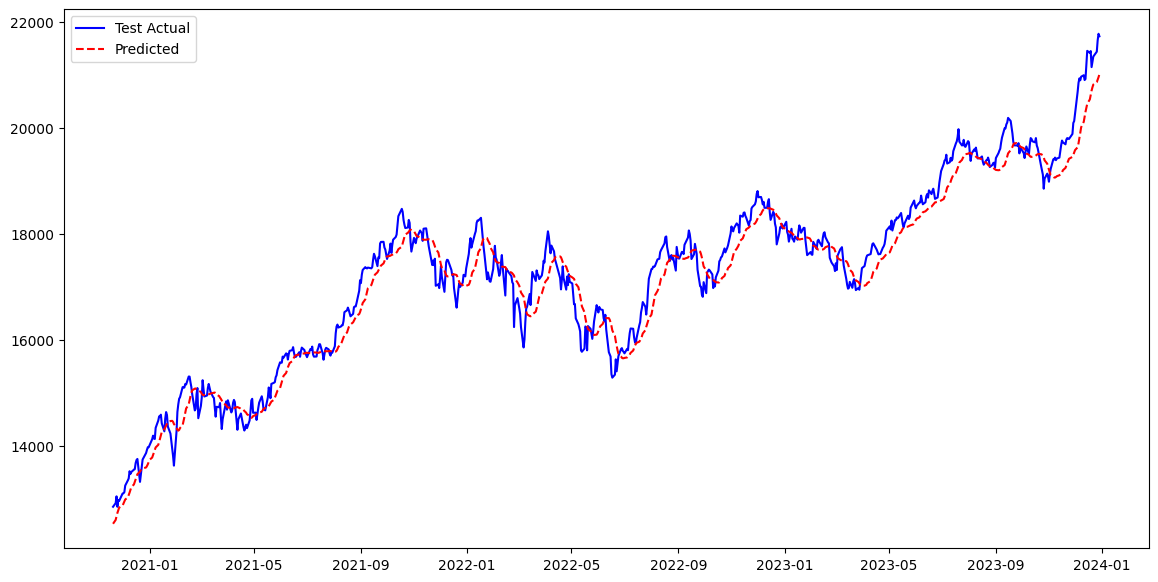

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import yfinance as yf
import seaborn as sns

# Download NIFTY 50 data
nifty = yf.download('^NSEI', start='2000-01-01', end='2024-01-01', progress=False)
df = nifty[['Close']]

# Scaling
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# Train-test split
train_size = int(len(df) * 0.8)
train, test = df_scaled[:train_size], df_scaled[train_size:]

# Create dataset
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i+time_step, 0])
        y.append(data[i+time_step, 0])
    return np.array(X), np.array(y)

time_step = 30
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)
X_train = X_train.reshape(-1, time_step, 1)
X_test = X_test.reshape(-1, time_step, 1)

# Model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2),
    LSTM(100),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=2, batch_size=32, validation_data=(X_test, y_test))

# Predictions
train_predict = scaler.inverse_transform(model.predict(X_train))
test_predict = scaler.inverse_transform(model.predict(X_test))
y_train_actual = scaler.inverse_transform([y_train])
y_test_actual = scaler.inverse_transform([y_test])

# Indices
train_index = df.index[:len(train_predict)]
test_index = df.index[len(df) - len(test_predict):]

# Visualization
plt.figure(figsize=(14, 7))
plt.plot(test_index, y_test_actual[0][:len(test_predict)], label='Test Actual', color='blue')
plt.plot(test_index, test_predict.flatten(), label='Predicted', linestyle='dashed', color='red')
plt.legend()
plt.show()
